<a href="https://colab.research.google.com/github/mlarthack/ami/blob/master/%5BResearch%5D_lucid_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### This notebook is based on "aligned interpolation" example from "diferrentiable image parametrizations" article on distill.pub

### The purpose of the notebook is to research possibilities of aligned interpolation of feature vizualization by feeding the result of previous optimization into the next

## Install, Import, Load Model

In [0]:
!pip install -q lucid>=0.2.3

In [0]:
# Imports

import numpy as np
import tensorflow as tf

import lucid.modelzoo.vision_models as models
from lucid.misc.io import load, save, show

import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render

In [0]:
from lucid.optvis.param import image, image_sample
from lucid.misc.tfutil import create_session

In [0]:
# Let's import a model from the Lucid modelzoo!

model = models.InceptionV1()
model.load_graphdef()

## Creating initial image


In [0]:
h, w = 512, 512


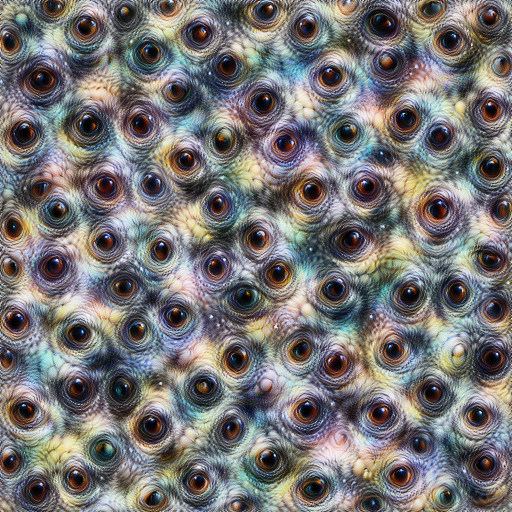

In [52]:
 with tf.Graph().as_default() as graph, tf.Session() as sess:
  N1 = render.make_vis_T(model, 'mixed4a_pre_relu:460', lambda: param.image(h, w, sd=0.42))
  tf.initialize_all_variables().run()
  
  for i in range(128):
    N1("vis_op").run()
    if not i + 1 % 128:
      show(N1("input").eval())
  init_im = N1("input").eval()
  test_sigmoid = (N1("input") * 10000).eval()

show(init_im)

# So, this is how more or less standard lucid looks like. 
# Our images will be a bit more colorfull...

In [0]:
def show_im(im):
  with tf.Session() as sess:

    t_image = im
    init_op = tf.global_variables_initializer()
    init_op.run()
    sess.run([t_image])
    img = t_image.eval()[0]
    show(img)

In [0]:
def render_from_image(objective, image, n_iter=50, sigmoid=False, show_progress=False):
    """returns list of frames"""
    frames = []
  
    with tf.Graph().as_default() as graph, tf.Session() as sess:
      
      # here I'm experimenting with constraints to make image less saturated...

      # this works as default
      #T = render.make_vis_T(model, objective, render.make_t_image(param.image(128)))

      # while this produces much more acid
      # T = render.make_vis_T(model, objective, tf.Variable(render.make_t_image(param.image(128))).value())

      # Any ideas? ;)
      if sigmoid: 
        var = tf.get_variable('image', initializer=image, constraint=lambda x: tf.nn.sigmoid(x))
      else:
        var = tf.get_variable('image', initializer=image, constraint=lambda x: tf.clip_by_value(x, 0, tf.nn.sigmoid(x)))
      T = render.make_vis_T(model, objective, var.value)

      tf.global_variables_initializer().run()

      for i in range(n_iter):
        sess.run([T('vis_op')])
        if show_progress and not i % 100:
          show(T("input").eval())
        frames.append(T("input").eval())
      
      return frames

In [0]:
im = render_from_image('mixed4d:42', init_im, n_iter=512, sigmoid=False)


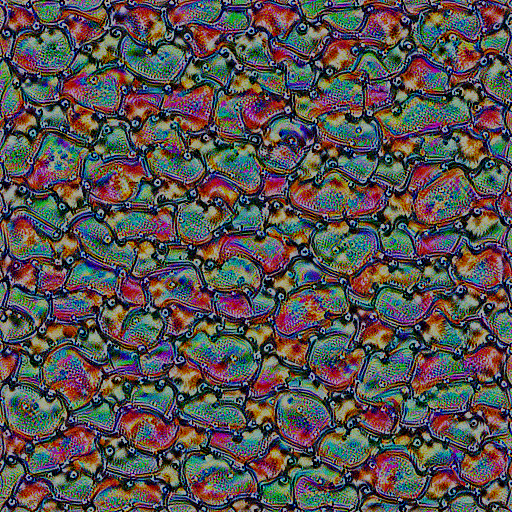

In [56]:
show(im[-1])

## Creating interpolated images


('mixed4d', 4)



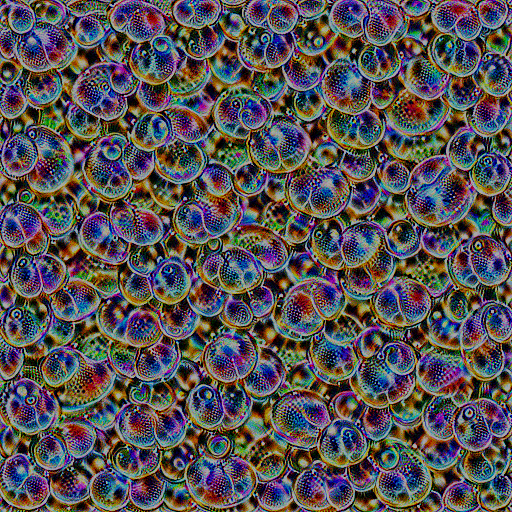

('mixed4d', 95)



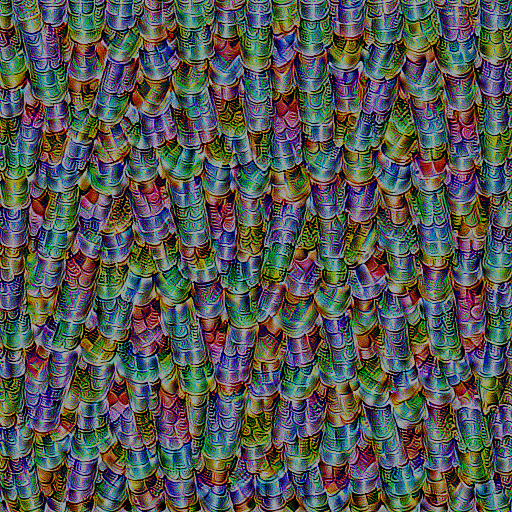

('mixed4d', 58)



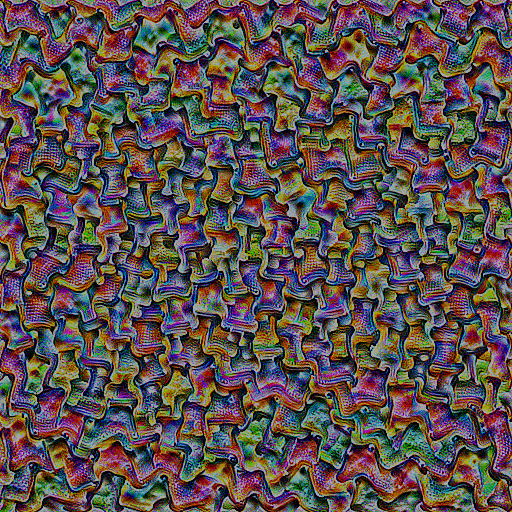

In [62]:
keyframes = [im[-1]]
obj = ('mixed4d', 42)
for _ in range(3):
  new_obj = 'mixed4d', np.random.randint(100)  # some random channel
  print(new_obj)
  # showing optimization via keyframes, because optimization looks ugly...
  n = 24  # number of keyframes
  for i in np.linspace(0, 1, n):
    inter_obj = objectives.Objective.sum([i * objectives.channel(*new_obj), 
                                          (1-i) * objectives.channel(*obj)])
    steps = render_from_image(inter_obj, keyframes[-1], n_iter=256, sigmoid=False)
    keyframes.append(steps[-1])
  obj = new_obj
  show(keyframes[-1])


## Making Video

In [0]:
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

from IPython.display import clear_output, Image, display

In [0]:
out_name = "lucid_interpolation"
writer = FFMPEG_VideoWriter(out_name+'.mp4', (h, w), 12.0)
with writer:
  for vis in keyframes:
    writer.write_frame(np.uint8(vis*255.0))